# Model Training

## Model

In [1]:
import os
import string  # Import the string module for alphabet letters
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:


# Define constants
input_shape = (256, 256, 1)  # Adjust based on your preprocessed image dimensions

# Function to build the CNN model
def build_cnn_model(num_classes):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(num_classes, activation='softmax'))

    return model

# Function to compile the model
def compile_model(model):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Function to apply data augmentation
def apply_data_augmentation(train_dir):
    # Extract alphabet letters
    alphabet_letters = string.ascii_uppercase
    classes = [folder for folder in os.listdir(train_dir) if folder.upper() in alphabet_letters]

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    return train_datagen.flow_from_directory(
        train_dir,
        target_size=(input_shape[0], input_shape[1]),
        batch_size=32,
        color_mode='grayscale',
        class_mode='categorical',
        classes=classes
    )

# Function to train the model
def train_model(model, train_generator, epochs=10):
    model.fit(train_generator, epochs=epochs)

# Function to evaluate the model
def evaluate_model(model, test_generator):
    return model.evaluate(test_generator)

# Specify the path to the preprocessed training images
preprocessed_train_images_folder_path = '/Users/aditya/Documents/GitHub/ASL/DATASET/SPLIT/train'

# Apply data augmentation
train_generator = apply_data_augmentation(preprocessed_train_images_folder_path)

# Build the CNN model
cnn_model = build_cnn_model(num_classes=len(train_generator.class_indices))

# Compile the model
compile_model(cnn_model)



Found 11524 images belonging to 17 classes.


In [ ]:
# Train the model
train_model(cnn_model, train_generator, epochs=17)

# Specify the path to the test images
test_dataset_folder_path = '/Users/aditya/Desktop/Class/DS675Machine Learning/Project/DATASET/SPLIT/test'

# Apply data augmentation to the test set
test_generator = apply_data_augmentation(test_dataset_folder_path)

# Evaluate the model on the test set
evaluation_result = evaluate_model(cnn_model, test_generator)
print("Evaluation Result:", evaluation_result)


# Make predictions on the test set
predictions = cnn_model.predict(test_generator)

# Get the class labels
class_labels = list(test_generator.class_indices.keys())

# Loop through each prediction and print the class label with its probability
for i, prediction in enumerate(predictions):
    predicted_class_index = tf.argmax(prediction).numpy()
    predicted_class_label = class_labels[predicted_class_index]
    predicted_probability = prediction[predicted_class_index]

    print(f"Sample {i + 1}: Predicted Class - {predicted_class_label}, Probability - {predicted_probability:.4f}")

save_path  = '/Users/aditya/Documents/GitHub/ASL/MODEL17'
cnn_model.save(save_path)

In [8]:
save_path  = '/Users/aditya/Documents/GitHub/ASL/MODEL17'
loaded_model = tf.keras.models.load_model(save_path)

## Prediction Functions

In [9]:
import cv2
import rembg
from PIL import Image
import numpy as np
import random
from IPython.display import Image as IPImage, display

# Function to capture an image from the default camera, remove the background, and preprocess it
def capture_and_preprocess():
    # Open the default camera (camera index 0)
    cap = cv2.VideoCapture(0)

    # Allow the camera to adjust (you may need to adjust the delay based on your camera)
    cv2.waitKey(1000)

    # Read a frame from the camera
    ret, frame = cap.read()

    # Release the camera capture
    cap.release()

    if ret:
        # Convert the OpenCV frame to a PIL Image
        pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

        # Use rembg to remove the background
        with rembg.remove(pil_image) as result:
            # Convert the result to an OpenCV format
            sign = cv2.cvtColor(np.array(result), cv2.COLOR_RGBA2BGRA)

        # Convert the image to grayscale
        grayscale_image = cv2.cvtColor(sign, cv2.COLOR_BGRA2GRAY)

        # Resize the image to the target size (256x256)
        target_size = (256, 256)
        resized_image = cv2.resize(grayscale_image, target_size)

        # Remove random noise (salt and pepper noise)
        noisy_image = Image.fromarray(resized_image)
        noisy_image = noisy_image.point(lambda p: p + random.choice([-50, 0, 50]) if random.random() < 0.05 else p)

        # Convert the noisy image back to NumPy array
        noisy_image_np = np.array(noisy_image)

        return frame, noisy_image_np
    else:
        print("Failed to capture an image.")
        return None

from gtts import gTTS
from IPython.display import Audio
from io import BytesIO

def text_to_speech(text):
    # Create a gTTS object with the desired text
    tts = gTTS(text=text, lang='en')

    # Save the generated speech to a BytesIO object
    audio_stream = BytesIO()
    tts.write_to_fp(audio_stream)
    audio_stream.seek(0)

    # Display the generated audio
    return Audio(data=audio_stream.read(), autoplay=True)





# Prediction

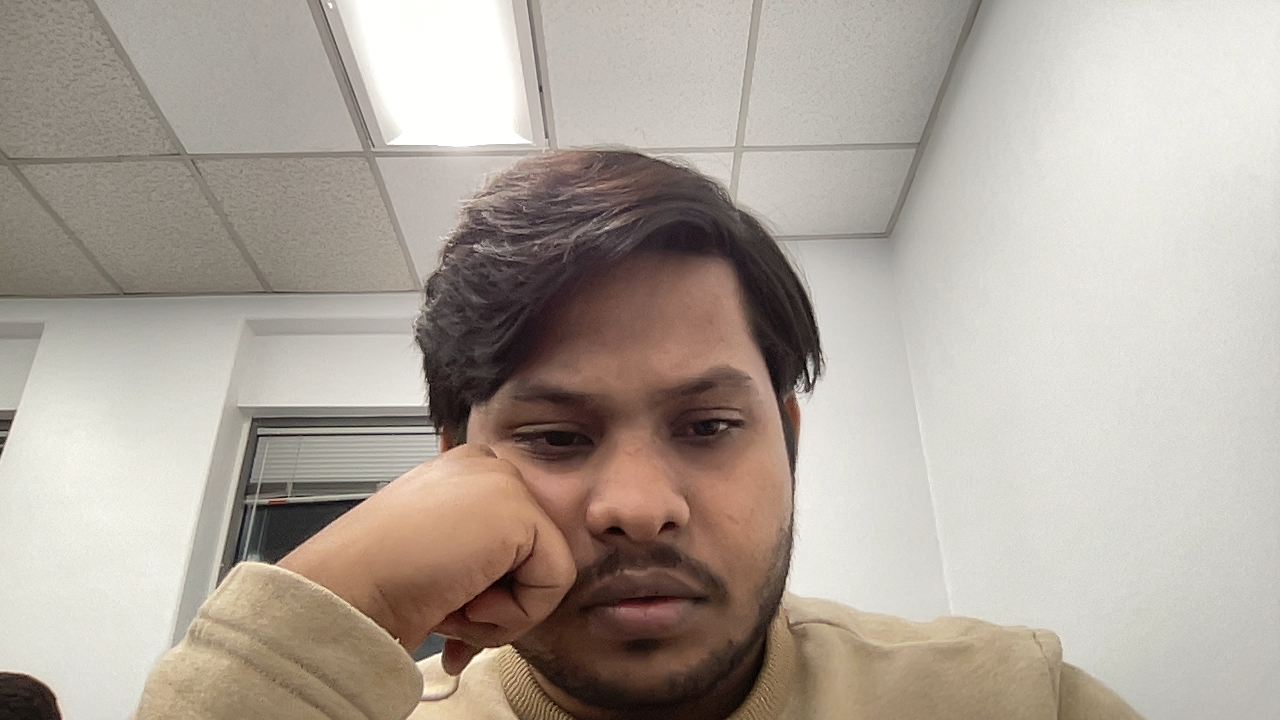

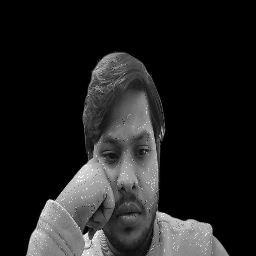

Image captured, background removed, and preprocessed.
1/1 [==============================] - 0s 206ms/step
Predicted Class - N, Probability - 0.7009
N


In [10]:
# Capture an image, remove the background, and preprocess it
input_image, preprocessed_image = capture_and_preprocess()

# Check if the preprocessed image was successfully captured
if preprocessed_image is not None:
    # Display the input image
    display(IPImage(data=cv2.imencode('.png', input_image)[1].tobytes(), format='png'))

    # Display the preprocessed image
    display(IPImage(data=cv2.imencode('.png', preprocessed_image)[1].tobytes(), format='png'))

    print("Image captured, background removed, and preprocessed.")
else:
    print("Image capture failed.")


# Assuming 'preprocessed_image' is your preprocessed image
input_array = np.expand_dims(preprocessed_image, axis=0)

# Make predictions on the input image
predictions = cnn_model.predict(input_array)



# Get the class labels
class_labels = list(train_generator.class_indices.keys())

# Find the class label with the highest probability
predicted_class_index = np.argmax(predictions)
predicted_class_label = class_labels[predicted_class_index]
predicted_probability = predictions[0, predicted_class_index]

# Print the predicted class label and its probability
print(f"Predicted Class - {predicted_class_label}, Probability - {predicted_probability:.4f}")


print(predicted_class_label)

text_input = predicted_class_label
audio_output = text_to_speech(text_input)

audio_output

In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

# Define constants
input_shape = (256, 256, 1)  # Adjust based on your preprocessed image dimensions
batch_size = 32
num_folds = 5  # Number of folds for cross-validation

# Function to build the CNN model
def build_cnn_model(num_classes):
    model = models.Sequential()
    
    # First Conv Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Second Conv Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Third Conv Block
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Flatten and Dense Layers
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    
    # Output Layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Function to compile the model
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

# Function to preprocess and load dataset into memory
def load_data(image_dir, target_size=(256, 256)):
    data = []
    labels = []
    class_names = sorted(os.listdir(image_dir))
    class_indices = {class_name: i for i, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        
        for file_name in os.listdir(class_path):
            file_path = os.path.join(class_path, file_name)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                img = tf.keras.preprocessing.image.load_img(file_path, target_size=target_size, color_mode='grayscale')
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                data.append(img_array)
                labels.append(class_indices[class_name])
    
    return np.array(data), np.array(labels), class_indices

# Perform k-fold cross-validation
def cross_validate(image_dir, num_folds=5, epochs=10):
    # Load the data and labels
    data, labels, class_indices = load_data(image_dir, target_size=input_shape[:2])
    data = data / 255.0  # Normalize the data
    labels = to_categorical(labels, num_classes=len(class_indices))  # One-hot encode labels

    # Initialize KFold
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)
    
    fold_no = 1
    all_fold_accuracies = []

    for train_idx, val_idx in kfold.split(data):
        print(f"Training fold {fold_no}/{num_folds}...")

        # Split data into training and validation
        train_data, val_data = data[train_idx], data[val_idx]
        train_labels, val_labels = labels[train_idx], labels[val_idx]

        # Build and compile the model
        model = build_cnn_model(num_classes=len(class_indices))
        compile_model(model)

        # Train the model
        history = model.fit(
            train_data, train_labels,
            validation_data=(val_data, val_labels),
            epochs=epochs,
            batch_size=batch_size
        )

        # Evaluate the model
        scores = model.evaluate(val_data, val_labels, verbose=0)
        print(f"Fold {fold_no} - Validation Accuracy: {scores[1] * 100:.2f}%")
        all_fold_accuracies.append(scores[1])

        # Save the model for the fold
        model.save(f'/mnt/d/ASL/models/cnn_model_fold_{fold_no}.h5')

        fold_no += 1

    # Calculate the average accuracy across all folds
    avg_accuracy = np.mean(all_fold_accuracies)
    print(f"Average Validation Accuracy: {avg_accuracy * 100:.2f}%")

    return all_fold_accuracies, avg_accuracy

# Paths
image_dir = r'D:\AmericanSignLanguage\Raw'

# Perform k-fold cross-validation
fold_accuracies, average_accuracy = cross_validate(image_dir, num_folds=num_folds, epochs=10)


Training fold 1/5...


C:\Users\ap2935\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2727 - loss: 1.8595 - val_accuracy: 0.0000e+00 - val_loss: 2.1111
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4091 - loss: 1.9523 - val_accuracy: 0.0000e+00 - val_loss: 2.0131
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.3182 - loss: 1.7492 - val_accuracy: 0.0000e+00 - val_loss: 1.5726
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 1.1680 - val_accuracy: 0.0000e+00 - val_loss: 1.1382
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7727 - loss: 0.6488 - val_accuracy: 0.6667 - val_loss: 0.7392
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8849 - val_accuracy: 1.0000 - val_loss: 0.4849
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8636 - loss: 0.3090 - val_accuracy: 1.0000 - val_loss: 0.3283
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9091 - loss: 0.2217 - val_accuracy: 1.0000 - val_loss: 0.2490


Fold 1 - Validation Accuracy: 100.00%
Training fold 2/5...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4091 - loss: 1.4513 - val_accuracy: 0.0000e+00 - val_loss: 1.1473
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2273 - loss: 1.9578 - val_accuracy: 0.1667 - val_loss: 0.7531
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5909 - loss: 1.6781 - val_accuracy: 1.0000 - val_loss: 0.6016
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7273 - loss: 0.8656 - val_accuracy: 1.0000 - val_loss: 0.4151
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8182 - loss: 0.2648 - val_accuracy: 1.0000 - val_loss: 0.2670
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6818 - loss: 0.6086 - val_accuracy: 1.0000 - val_loss: 0.1757
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6818 - loss: 0.4816 - val_accuracy: 1.0000 - val_loss: 0.1263
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7727 - loss: 0.

Fold 2 - Validation Accuracy: 100.00%
Training fold 3/5...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2273 - loss: 2.4254 - val_accuracy: 0.0000e+00 - val_loss: 3.5821
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 2.6912 - val_accuracy: 0.0000e+00 - val_loss: 2.6092
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5000 - loss: 2.8904 - val_accuracy: 0.0000e+00 - val_loss: 1.4538
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5909 - loss: 1.8350 - val_accuracy: 0.3333 - val_loss: 0.8393
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 2.1507 - val_accuracy: 0.8333 - val_loss: 0.5226
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8636 - loss: 0.8324 - val_accuracy: 1.0000 - val_loss: 0.3658
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6364 - loss: 1.0647 - val_accuracy: 1.0000 - val_loss: 0.2553
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7727 - 

Fold 3 - Validation Accuracy: 100.00%
Training fold 4/5...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.4348 - loss: 1.3608 - val_accuracy: 0.0000e+00 - val_loss: 2.6979
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6087 - loss: 1.5951 - val_accuracy: 0.0000e+00 - val_loss: 1.3846
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.5652 - loss: 1.6778 - val_accuracy: 0.0000e+00 - val_loss: 0.9151
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7391 - loss: 0.4188 - val_accuracy: 0.8000 - val_loss: 0.6085
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8696 - loss: 0.2723 - val_accuracy: 1.0000 - val_loss: 0.3963
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.8261 - loss: 0.3880 - val_accuracy: 1.0000 - val_loss: 0.2645
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 1.0000 - loss: 0.0618 - val_accuracy: 1.0000 - val_loss: 0.1724
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9130 - 

Fold 4 - Validation Accuracy: 100.00%
Training fold 5/5...
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.3043 - loss: 1.8357 - val_accuracy: 0.0000e+00 - val_loss: 2.4006
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2609 - loss: 2.4518 - val_accuracy: 0.0000e+00 - val_loss: 1.3510
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.4348 - loss: 1.6097 - val_accuracy: 0.0000e+00 - val_loss: 0.8343
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6957 - loss: 1.0369 - val_accuracy: 0.8000 - val_loss: 0.6172
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6522 - loss: 0.8776 - val_accuracy: 1.0000 - val_loss: 0.4698
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7826 - loss: 0.4009 - val_accuracy: 1.0000 - val_loss: 0.3558
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9565 - loss: 0.1544 - val_accuracy: 1.0000 - val_loss: 0.2765
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.9130 - 

Fold 5 - Validation Accuracy: 100.00%
Average Validation Accuracy: 100.00%
